### **This Notebook Evaluates Group KFold Cross-Validation to Better Measure how the model generalises**

Group KFold Cross-Validation prevents spectra from the same Surface appearing within both the training and test folds.

This gives a better indication of the model's ability to generalise, as it stops leakage between samples from the same fold.

Import Libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.model_selection import LeavePGroupsOut

Read the spectral data

In [3]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

Filter the effective range from 380/400 to 1800 cm-1

In [4]:
#df = df[(df['WaveNumber'] >= 320) & (df['WaveNumber'] <= 1800)]
#df = df[(df['WaveNumber'] >= 380) & (df['WaveNumber'] <= 1800)]
#df = df[(df['WaveNumber'] >= 400) & (df['WaveNumber'] <= 1800)]
df = df[(df['WaveNumber'] >= 400) & (df['WaveNumber'] <= 1800)]

df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


In [5]:
#df.to_csv("../../data/exosomes.raw_spectrum_400-1800.csv", index=False)

In [6]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6239205 entries, 293 to 8023281
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SpecID      object 
 1   Seq         int64  
 2   WaveNumber  float64
 3   Absorbance  float64
 4   SurID       object 
 5   Status      object 
dtypes: float64(2), int64(1), object(3)
memory usage: 333.2+ MB


#### Train an Extra Trees Classifier on the full spectrum.

In [8]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    # Include the SurID to perform GroupKFold CV
    statuses_and_surface = df[['SpecID', 'SurID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses_and_surface, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [9]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [10]:
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1765.6628,1774.7809,1769.0302,1756.4220,1758.8690,1763.2300,1745.2285,1773.3534,1774.7166,1753.3281,...,1210.4993,1213.9619,1225.2153,1210.0010,1210.6858,1194.4679,1195.1451,1189.8683,201210-1,Normal
201210-1-01,1966.9930,1962.4237,1954.5616,1954.3228,1963.0917,1975.0807,1979.3162,1963.4561,1968.4587,1964.0000,...,1382.6973,1363.7004,1360.6210,1354.0477,1353.0381,1353.9978,1361.2426,1370.2874,201210-1,Normal
201210-1-02,2182.6694,2149.6565,2146.0227,2159.3459,2167.2910,2160.9861,2145.6575,2134.2004,2142.8303,2138.6309,...,1976.2070,1989.0183,1996.2838,1979.3507,1976.2002,1994.9839,1974.2030,1971.1880,201210-1,Normal
201210-1-03,2445.0837,2430.4973,2422.7927,2434.3433,2454.9700,2462.8245,2454.7007,2467.7329,2449.5161,2421.3474,...,1992.3817,2022.6331,2001.8311,2010.0946,2006.4933,2017.2891,2038.1699,2000.6475,201210-1,Normal
201210-1-04,2250.4536,2248.6235,2245.0984,2242.7173,2235.2803,2228.9585,2236.0095,2229.6091,2225.9231,2211.0359,...,2009.0385,1953.3303,1963.5698,1964.5299,1969.5634,1986.6266,1970.1484,2007.0848,201210-1,Normal


>**The Count of Surface IDs and the number of associated samples**

In [11]:
len(wavelength_df.groupby(['SurID']))

63

In [12]:
wavelength_df.groupby(['SurID', 'Status']).size().reset_index(name='Count of Spectra per Surface')

,SurID,Status,Count of Spectra per Surface
0,201210-1,Normal,49
1,201210-2,Normal,50
2,210114-1,Normal,50
3,210114-2,Normal,50
4,210120-1,Hyperglycemia,50
...,...,...,...
58,210519-3,Hyperglycemia,50
59,210524-1,Hypoglycemia,15
60,210526-1,Hyperglycemia,50
61,210526-2,Hyperglycemia,15


It looks like each Surface is associated with 1 Status

>**The Count of Spectra with each Status**

In [13]:
df.groupby('Status')['SpecID'].nunique().reset_index(name='Spectra Count')

,Status,Spectra Count
0,Hyperglycemia,915
1,Hypoglycemia,1065
2,Normal,1065


>**The Count of Surfaces with each Status**

In [14]:
df.groupby('Status')['SurID'].nunique().reset_index(name='Surface Count')

,Status,Surface Count
0,Hyperglycemia,19
1,Hypoglycemia,22
2,Normal,22


>#### **Train an Extra Trees Classifier on the Raw Spectrum and evaluate it with GroupKFold cross-validation.**

Ensures that spectra from the same surface are not contained within the same CV folds out to evaluate the models ability to generalise on independent samples.

In [15]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = []
    for train_index, test_index in cv.split(X, y, groups):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the Extra Trees classifier
        et.fit(X_train, y_train)
        predictions = et.predict(X_test)
        
        # Evaluate the model
        score = accuracy_score(y_test, predictions)
        scores.append(score)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [16]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5350 +/- 0.1277


>Scale the absorbances to the highest peak in each spectrum.

In [17]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalised_absorbances = absorbances / max_value
    return normalised_absorbances

In [18]:
def vector_normalise(absorbances):
    l2_norm = np.sqrt(np.sum(absorbances**2))  # Calculate the euclidean norm
    normalised_absorbances = absorbances / l2_norm
    return normalised_absorbances

In [19]:
def svn_normalise(absorbances):
    mean = absorbances.mean()
    std = absorbances.std()
    return (absorbances - mean) / std

> Now see the effect of removing spikes caused by cosmic rays

Locate and correct the spikes

In [20]:
# # https://towardsdatascience.com/data-science-for-raman-spectroscopy-a-practical-example-e81c56cf25f

# def modified_z_score(ys):
#     ysb = np.diff(ys) # Differentiated intensity values
#     median_y = np.median(ysb) # Median of the intensity values
#     median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
#     modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
#     return modified_z_scores
    
# # The next function calculates the average values around the point to be replaced.
# def fixer(y,ma):
#     threshold = 7 # binarisation threshold
    
#     spikes = abs(np.array(modified_z_score(y))) > threshold
#     y_out = y.copy()
#     for i in np.arange(len(spikes)):
#         if spikes[i] != 0:
#             w = np.arange(i-ma,i+1+ma)
#             we = w[spikes[w] == 0]
#             if len(we) > 0:  # Check if it has at least one valid value
#                 y_out[i] = np.mean(y[we])
#     return y_out

# def despike_group(absorbances):
#     absorbance_data = absorbances.to_numpy()
#     despiked_absorbance = fixer(absorbance_data, ma=20) # Tuned based on ml performance
#     return(despiked_absorbance)

# df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

In [21]:
# # https://towardsdatascience.com/removing-spikes-from-raman-spectra-8a9fdda0ac22

# def modified_z_score(intensity):
#     median_int = np.median(intensity)
#     mad_int = np.median([np.abs(intensity - median_int)])
#     modified_z_scores = 0.6745 * (intensity - median_int) / mad_int
#     return modified_z_scores
    
# # The next function calculates the average values around the point to be replaced.
# def fixer(y,m):
#     threshold = 7 # binarization threshold.
#     threshold = 3.5 # binarization threshold. 

#     spikes = abs(np.array(modified_z_score(np.diff(y)))) > threshold
#     y_out = y.copy() # So we don’t overwrite y 

#     for i in np.arange(len(spikes)):
#         if spikes[i] != 0: # If we have an spike in position i
#             w = np.arange(i-m,i+1+m) # we select 2 m + 1 points around our spike
#             w2 = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
#             y_out[i] = np.mean(y[w2]) # and we average their values

# def despike_group(absorbances):
#     absorbance_data = absorbances.to_numpy()
#     despiked_absorbance = fixer(absorbance_data, m=20) # Tuned based on ml performance
#     return(despiked_absorbance)

# df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

In [22]:
# # Doing this to check the combination
# df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

In [23]:
#despiked_df = prepare_wavelength_df(df, 'Despiked_Absorbance')

This seems to cause a small degradation to performance.

>Calculate the baseline using Asymmetric Least Squares, then subtract it from the spectrum.

In [24]:
from pybaselines.whittaker import asls
from pybaselines.whittaker import airpls
from pybaselines.polynomial import imodpoly

def asls_baseline_correction(x, lam, p):
        corrected, _ = asls(x, lam=lam, p=p)
        #corrected, _ = airpls(x, lam=lam)
        return corrected

def polyfit_baseline(x):
        corrected, _ = imodpoly(x, poly_order=5)
        return corrected

In [25]:
help(imodpoly)

Help on function imodpoly in module pybaselines.polynomial:

imodpoly(data, x_data=None, poly_order=2, tol=0.001, max_iter=250, weights=None, use_original=False, mask_initial_peaks=True, return_coef=False, num_std=1)
    The improved modofied polynomial (IModPoly) baseline algorithm.
    
    Parameters
    ----------
    data : array-like, shape (N,)
        The y-values of the measured data, with N data points.
    x_data : array-like, shape (N,), optional
        The x-values of the measured data. Default is None, which will create an
        array from -1 to 1 with N points.
    poly_order : int, optional
        The polynomial order for fitting the baseline. Default is 2.
    tol : float, optional
        The exit criteria. Default is 1e-3.
    max_iter : int, optional
        The maximum number of iterations. Default is 250.
    weights : array-like, shape (N,), optional
        The weighting array. If None (default), then will be an array with
        size equal to N and all val

The PyBaselines Library Performs this much faster.

Here is an example on 1 spectrum

In [26]:
sample = df[df['SpecID'] == "210526-3-06"]
sample

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
8013328,210526-3-06,293,400.22778,2367.7305,210526-3,Hyperglycemia
8013329,210526-3-06,294,400.91116,2352.8223,210526-3,Hyperglycemia
8013330,210526-3-06,295,401.59454,2377.9473,210526-3,Hyperglycemia
8013331,210526-3-06,296,402.27789,2394.0313,210526-3,Hyperglycemia
8013332,210526-3-06,297,402.96127,2376.4995,210526-3,Hyperglycemia
...,...,...,...,...,...,...
8015372,210526-3-06,2337,1797.03870,1967.4805,210526-3,Hyperglycemia
8015373,210526-3-06,2338,1797.72200,1965.0815,210526-3,Hyperglycemia
8015374,210526-3-06,2339,1798.40550,1947.5498,210526-3,Hyperglycemia
8015375,210526-3-06,2340,1799.08890,1951.8849,210526-3,Hyperglycemia


/tmp/ipykernel_369811/3869353767.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

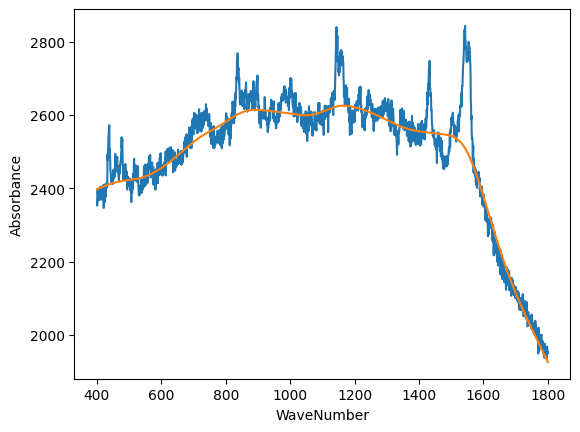

In [50]:
lam = 10**7
p = 0.3


# sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: polyfit_baseline(x))
sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.lineplot(x="WaveNumber", y="Baseline", data=sample)

Subtract the baseline.

/tmp/ipykernel_369811/1303904700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']


<Axes: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

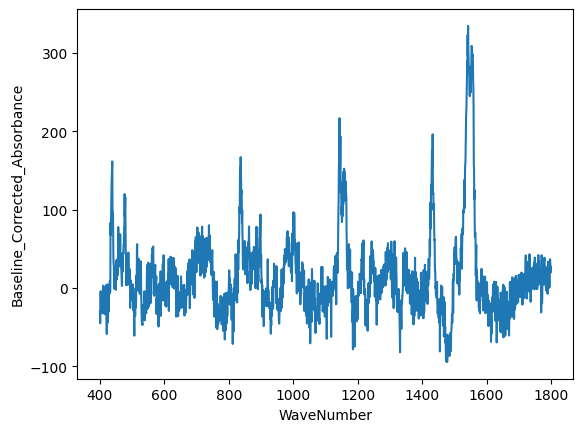

In [51]:
sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)

Remove the noise from the spectra using Savitzky–Golay-filtering on the raw spectrum.

/tmp/ipykernel_369811/2581658110.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

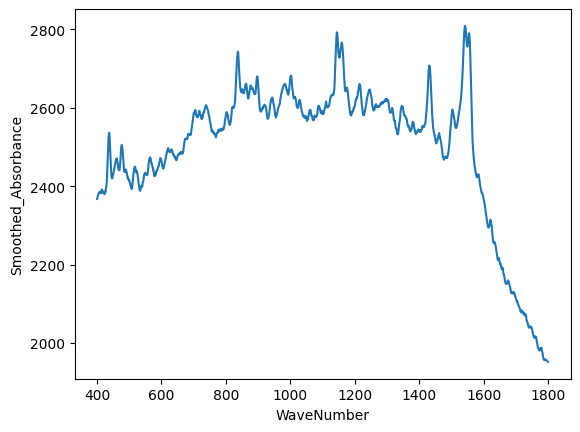

In [52]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 21
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

Try it on the Baseline_Corrected_Spectrum

/tmp/ipykernel_369811/1425479424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

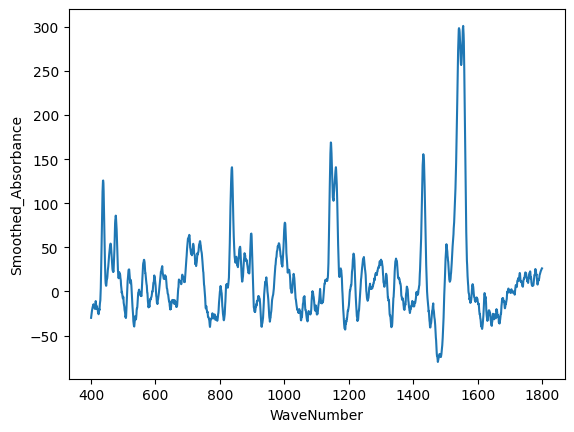

In [53]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

>Based on hand tuned parameters lets see how they affect the Machine Learning Classification.

In [54]:
#df['Baseline_Corrected_Absorbance'] = df['Absorbance'] - df.groupby('SpecID')['Absorbance'].transform(lambda x: polyfit_baseline(x))
df['Baseline_Corrected_Absorbance'] = df['Absorbance'] - df.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))

In [55]:
df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Baseline_Corrected_Absorbance,Scaled_Baseline_Corrected,Smoothed_Baseline,Scaled_Smooth_Baseline
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,7.525075,0.072587,12.073072,-0.087176
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,16.941166,0.132386,11.963197,-0.091662
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,11.488456,0.097692,11.859525,-0.095895
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,-0.821755,0.019417,11.762056,-0.099874
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,1.923231,0.036821,11.670788,-0.103601


In [56]:
baseline_corrected_df = prepare_wavelength_df(df, 'Baseline_Corrected_Absorbance')

In [57]:
baseline_corrected_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,7.525075,16.941166,11.488456,-0.821755,1.923231,6.582215,-11.121305,17.301569,18.962738,-2.127801,...,12.095768,16.228948,28.152926,13.609205,14.964584,-0.582736,0.765044,-3.841175,201210-1,Normal
201210-1-01,-7.785115,-11.953514,-19.414712,-19.252608,-10.082800,2.307117,6.943547,-8.515604,-3.112032,-7.169733,...,43.113231,24.907155,22.618564,16.836061,16.617250,18.367733,26.403313,36.238892,201210-1,Normal
201210-1-02,30.640243,-1.955767,-5.172677,8.567411,16.929397,11.041380,-3.870341,-14.910567,-5.863801,-9.646341,...,13.113115,26.818277,34.977627,18.938367,16.681702,36.359233,16.472163,14.350993,201210-1,Normal
201210-1-03,-3.821892,-17.985016,-25.266340,-13.292463,7.757520,16.035312,8.334817,21.790340,3.996882,-23.748453,...,-5.633534,26.029166,6.638451,16.313225,14.123191,26.330251,48.622310,12.511168,201210-1,Normal
201210-1-04,19.071352,17.592241,14.418129,12.388016,5.301999,-0.668823,6.733148,0.683709,-2.651340,-17.187604,...,44.038316,-10.393604,1.122161,3.358514,9.668257,28.007694,12.805728,51.018360,201210-1,Normal


In [58]:
evaluate_extra_trees(baseline_corrected_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5511 +/- 0.1339


Scale the Baseline Corrected Absorbances to the highest peak.

In [59]:
df['Scaled_Baseline_Corrected'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: normalise(x))

In [60]:
scaled_baseline_df = prepare_wavelength_df(df, 'Scaled_Baseline_Corrected')

> Lets try 2 different Savitsky Golay Approaches on the Raw and Baseline Corrected Spectra with and without scaling

Try this on the baseline corrected spectra.

In [61]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 21
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [62]:
smooth_baseline = prepare_wavelength_df(df, 'Smoothed_Baseline')

In [63]:
evaluate_extra_trees(smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5735 +/- 0.1292


In [64]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: normalise(x))

In [65]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [66]:
evaluate_extra_trees(scaled_smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5558 +/- 0.1105


In [67]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: vector_normalise(x))

In [68]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [69]:
evaluate_extra_trees(scaled_smooth_baseline)

In [ ]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: svn_normalise(x))

In [ ]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [ ]:
evaluate_extra_trees(scaled_smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5641 +/- 0.0818
